# Plot loss and accuracy of a trained model

In [1]:
# imports
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import io

# get data
!wget --no-check-certificate \
    -O /tmp/sentiment.csv https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P

# define get_data function
def get_data(path):
  data = pd.read_csv(path, index_col=0)
  return data

#get the data
data = get_data('/tmp/sentiment.csv')

# clone package repository
!git clone https://github.com/vallantin/atalaia.git

# navigate to atalaia directory
%cd atalaia

# install packages requirements
!pip install -r requirements.txt

# install package
!python setup.py install

# import it
from atalaia.atalaia import Atalaia

#def pre-process function
def preprocess(panda_series):
  atalaia = Atalaia('en')

  # lower case everyting and remove double spaces
  panda_series = (atalaia.lower_remove_white(t) for t in panda_series)

  # expand contractions
  panda_series = (atalaia.expand_contractions(t) for t in panda_series)

  # remove punctuation
  panda_series = (atalaia.remove_punctuation(t) for t in panda_series)

  # remove numbers
  panda_series = (atalaia.remove_numbers(t) for t in panda_series)

  # remove stopwords
  panda_series = (atalaia.remove_stopwords(t) for t in panda_series)

  # remove excessive spaces
  panda_series = (atalaia.remove_excessive_spaces(t) for t in panda_series)

  return panda_series

# preprocess it
preprocessed_text = preprocess(data.text)

# assign preprocessed texts to dataset
data['text']      = list(preprocessed_text)

# split train/test
# shuffle the dataset
data = data.sample(frac=1)

# separate all classes present on the dataset
classes_dict = {}
for label in [0,1]:
  classes_dict[label] = data[data['sentiment'] == label]

# get 80% of each label
size = int(len(classes_dict[0].text) * 0.8)
X_train = list(classes_dict[0].text[0:size])      + list(classes_dict[1].text[0:size])
X_test  = list(classes_dict[0].text[size:])       + list(classes_dict[1].text[size:])
y_train = list(classes_dict[0].sentiment[0:size]) + list(classes_dict[1].sentiment[0:size])
y_test  = list(classes_dict[0].sentiment[size:])  + list(classes_dict[1].sentiment[size:])

# Convert labels to Numpy arrays
y_train = np.array(y_train)
y_test = np.array(y_test)

# Let's consider the vocab size as the number of words
# that compose 90% of the vocabulary
atalaia    = Atalaia('en')
vocab_size = len(atalaia.representative_tokens(0.9, 
                                               ' '.join(X_train),
                                               reverse=False))
oov_tok = "<OOV>"

# start tokenize
tokenizer = Tokenizer(num_words=vocab_size, 
                      oov_token=oov_tok)

# fit on training
# we don't fit on test because, in real life, our model will have to deal with
# words ir never saw before. So, it makes sense fitting only on training.
# when it finds a word it never saw before, it will assign the 
# <OOV> tag to it.
tokenizer.fit_on_texts(X_train)

# get the word index
word_index = tokenizer.word_index

# transform into sequences
# this will assign a index to the tokens present on the corpus
sequences = tokenizer.texts_to_sequences(X_train)

# define max_length 
max_length = 100

# post: pad or truncate after sentence.
# pre: pad or truncate before sentence.
trunc_type='post'
padding_type='post'

padded = pad_sequences(sequences,
                       maxlen=max_length, 
                       padding=padding_type, 
                       truncating=trunc_type)

# tokenize and pad test sentences
# thse will be used later on the model for accuracy test
X_test_sequences = tokenizer.texts_to_sequences(X_test)

X_test_padded    = pad_sequences(X_test_sequences,
                                 maxlen=max_length, 
                                 padding=padding_type, 
                                 truncating=trunc_type)

# create the reverse word index
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# create the decoder
def text_decoder(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])


--2020-07-07 05:49:52--  https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P
Resolving drive.google.com (drive.google.com)... 74.125.133.100, 74.125.133.102, 74.125.133.138, ...
Connecting to drive.google.com (drive.google.com)|74.125.133.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/vm7l6h4vnlfcakrmh2ejif4p25g364am/1594100925000/11118900490791463723/*/13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P [following]
--2020-07-07 05:49:52--  https://doc-08-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/vm7l6h4vnlfcakrmh2ejif4p25g364am/1594100925000/11118900490791463723/*/13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P
Resolving doc-08-ak-docs.googleusercontent.com (doc-08-ak-docs.googleusercontent.com)... 173.194.76.132, 2a00:1450:400c:c00::84
Connecting to doc-08-ak-docs.googleusercontent.com (doc-08-ak-docs.googleusercontent.com)|173.19

Build and compile the model

In [2]:
# Build network
embedding_dim = 100

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

When training the model, assign the training process to the variable history.

In [3]:
# train the model
num_epochs = 10
history = model.fit(padded, 
                    y_train, 
                    epochs=num_epochs,
                    batch_size=32,
                    validation_split=0.2,
                    shuffle=True)
    

Epoch 1/10
40/40 [==============================] - 1s 17ms/step - loss: 0.6913 - accuracy: 0.5821 - val_loss: 0.9354 - val_accuracy: 0.0000e+00
Epoch 2/10
40/40 [==============================] - 0s 9ms/step - loss: 0.6619 - accuracy: 0.6253 - val_loss: 0.9789 - val_accuracy: 0.0000e+00
Epoch 3/10
40/40 [==============================] - 0s 9ms/step - loss: 0.5906 - accuracy: 0.6701 - val_loss: 0.8386 - val_accuracy: 0.3887
Epoch 4/10
40/40 [==============================] - 0s 9ms/step - loss: 0.3218 - accuracy: 0.8916 - val_loss: 0.9729 - val_accuracy: 0.5768
Epoch 5/10
40/40 [==============================] - 0s 9ms/step - loss: 0.1135 - accuracy: 0.9694 - val_loss: 0.9083 - val_accuracy: 0.7085
Epoch 6/10
40/40 [==============================] - 0s 9ms/step - loss: 0.0389 - accuracy: 0.9914 - val_loss: 0.9869 - val_accuracy: 0.7116
Epoch 7/10
40/40 [==============================] - 0s 9ms/step - loss: 0.0244 - accuracy: 0.9945 - val_loss: 1.4660 - val_accuracy: 0.6458
Epoch 8/10


History holds information about the loss and the accuracy captured during training.

In [4]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


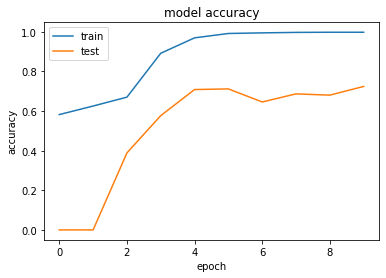

In [5]:
# Accuracy history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

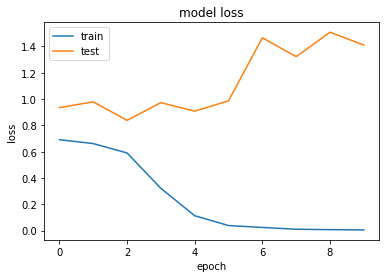

In [6]:
# Loss history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [7]:
accuracy = model.evaluate(X_test_padded, y_test)[1]
print('Model accuracy is {:.2f}%'.format(accuracy*100))

13/13 [==============================] - 0s 3ms/step - loss: 0.8449 - accuracy: 0.7975
Model accuracy is 79.75%
